# Examining the difference between mean minimum and maximum daily temperatures at UBC and SFU

## 1. Introduction

Students applying to the University of British Columbia (UBC) and Simon Fraser University (SFU) may consider campus weather in their decision process between the schools. Studies have shown that temperature has an impact on student productivity and emotional stability (1, 2). Temperature has also been observed to impact the daily academic routines of students (3). Colder temperatures tends to lead to lower class attendance, while hotter temperatures results in decreased self-study hours (3). Therefore, temperature can serve as a criterion when selecting a university. 

Our study aims to see whether there is a significant difference in mean daily minimum and maximum temperature between UBC and SFU. The dataset we will use compiles daily weather variables recorded from January to June in 1995 (4). Our location parameters will be the true mean daily minimum and maximum temperature across all years for UBC and SFU, which we will estimate using the bootstrap distribution generated from our dataset. Overall, we hope our findings will support future research on relationships between temperature and academic success. 

## 2. Methods and Results

This section consists of:
- 2.1. R Preamble
- 2.2. Preliminary Results
- 2.3. Data Analysis

### 2.1. R Preamble

In [1]:
# Run this first.
library(tidyverse)
library(tidymodels)

set.seed(2023)
options(repr.plot.width = 8, repr.plot.height = 6)

SRC <-
    c("https://raw.githubusercontent.com/arthu-rguo/stat-201-proj/main/ubc.csv",
      "https://raw.githubusercontent.com/arthu-rguo/stat-201-proj/main/sfu.csv")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### 2.2. Preliminary Results

#### 2.2.1. Loading and wrangling the dataset

Note that the raw UBC and SFU datasets span different date ranges. However, our analysis will focus mainly on the minimum and maximum daily temperatures, which might vary depending on the date. To prevent this from potentially skewing our results, we filter our wrangled dataset such that it spans the intersection of the UBC and SFU date ranges (from January 1 to June 30, 1995).

In [2]:
# Load and label the raw datasets for UBC and SFU, respectively.
ubc_raw <- read_csv(SRC[1], show_col_types = FALSE) |>
    mutate(location = as.factor("UBC"))

sfu_raw <- read_csv(SRC[2], show_col_types = FALSE) |>
    mutate(location = as.factor("SFU"))

# Join the datasets, select the relevant variables, and tidy the data.
ubc_sfu_raw <- bind_rows(ubc_raw, sfu_raw) |>
    rename(date_time = "Date/Time", 
           min_temp_c = "Min Temp (°C)", max_temp_c = "Max Temp (°C)") |>
    select(location, date_time, min_temp_c, max_temp_c) |>
    filter(!is.na(min_temp_c), !is.na(max_temp_c))

# Find the intersection of the date ranges and filter the dataset.
date_range <- ubc_sfu_raw |>
    group_by(location) |>
    summarize(min = min(date_time), max = max(date_time)) |>
    ungroup() |>
    summarize(min = max(min), max = min(max))

ubc_sfu_data <- ubc_sfu_raw |>
    filter(between(date_time, date_range$min, date_range$max))

# Preview the dataset.
cat("Table 1. Preview of tidy data for UBC and SFU")
head(ubc_sfu_data)
tail(ubc_sfu_data)

Table 1. Preview of tidy data for UBC and SFU

location date_time  min_temp_c max_temp_c
1 UBC      1995-01-01 -3.5       4.0       
2 UBC      1995-01-02 -3.5       4.0       
3 UBC      1995-01-03 -4.5       4.5       
4 UBC      1995-01-04 -5.0       4.0       
5 UBC      1995-01-05 -4.0       3.0       
6 UBC      1995-01-06 -4.0       3.0

location date_time  min_temp_c max_temp_c
1 SFU      1995-06-25 12         24.0      
2 SFU      1995-06-26 12         22.0      
3 SFU      1995-06-27 16         25.0      
4 SFU      1995-06-28 19         29.0      
5 SFU      1995-06-29 20         29.5      
6 SFU      1995-06-30 21         30.0

#### 2.2.2. Summary statistics

We calculate the summary statistics of interest for both UBC and SFU. The sample sizes are slightly different, but this should not a problem as both asymptotic and bootstrapping methods can account for this.

Overall, we can see that the mean minimum daily temperature at UBC in 1995 was 6.28°C, which is higher than the mean minimum daily temperature of 5.73°C at SFU, but both mean maximum daily temperatures are very similar at around 13.11°C.

In [3]:
# Calculate means, standard deviations, and counts for both locations.
ubc_sfu_summary <- ubc_sfu_data |>
    group_by(location) |>
    summarize(mean_min = mean(min_temp_c), sd_min = sd(min_temp_c),
              mean_max = mean(max_temp_c), sd_max = sd(max_temp_c),
              n = n())

# Store these values for later use.
ubc_mean_min <- ubc_sfu_summary$mean_min[1]
ubc_mean_max <- ubc_sfu_summary$mean_max[1]
ubc_sd_min <- ubc_sfu_summary$sd_min[1]
ubc_sd_max <- ubc_sfu_summary$sd_max[1]
ubc_n <- ubc_sfu_summary$n[1]

sfu_mean_min <- ubc_sfu_summary$mean_min[2]
sfu_mean_max <- ubc_sfu_summary$mean_max[2]
sfu_sd_min <- ubc_sfu_summary$sd_min[2]
sfu_sd_max <- ubc_sfu_summary$sd_max[2]
sfu_n <- ubc_sfu_summary$n[2]

cat("Table 2. Summary statistics for UBC and SFU")
ubc_sfu_summary

Table 2. Summary statistics for UBC and SFU

location mean_min sd_min   mean_max sd_max   n  
1 UBC      6.279006 4.821630 13.10773 5.523258 181
2 SFU      5.770950 4.812559 13.11732 6.357132 179

#### 2.2.3. Preliminary visualization

Plotting and comparing the sample distributions for both locations suggests that minimum and maximum daily temperatures might not be normally distributed—in particular, the distributions for UBC seem somewhat bimodal. Nonetheless, our sample sizes of 179 and 181 are still large enough for the Central Limit Theorem (CLT) to apply.

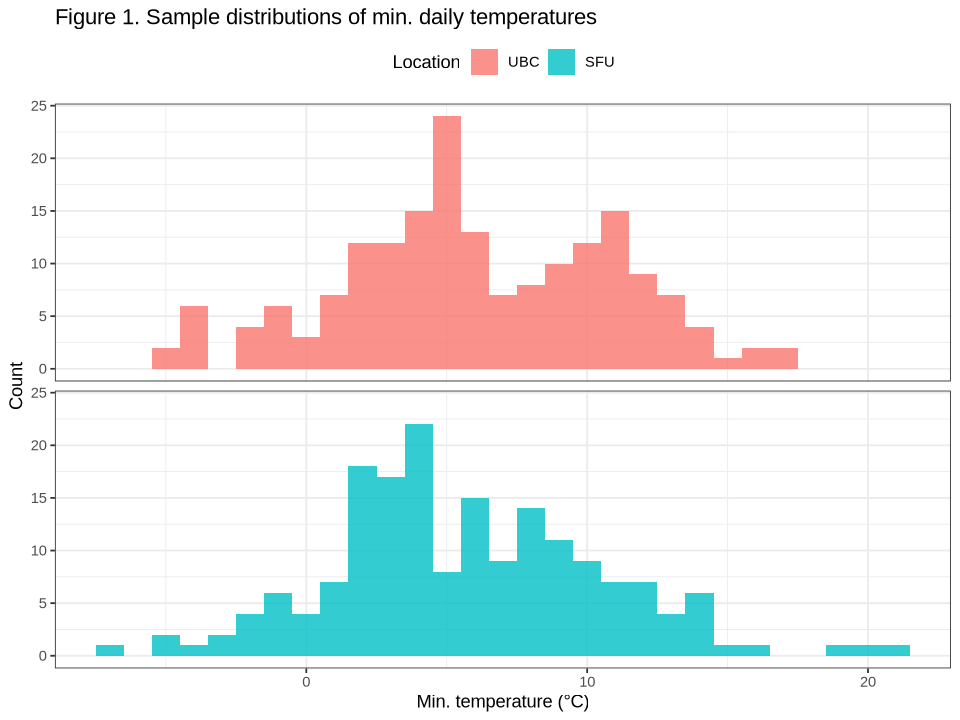

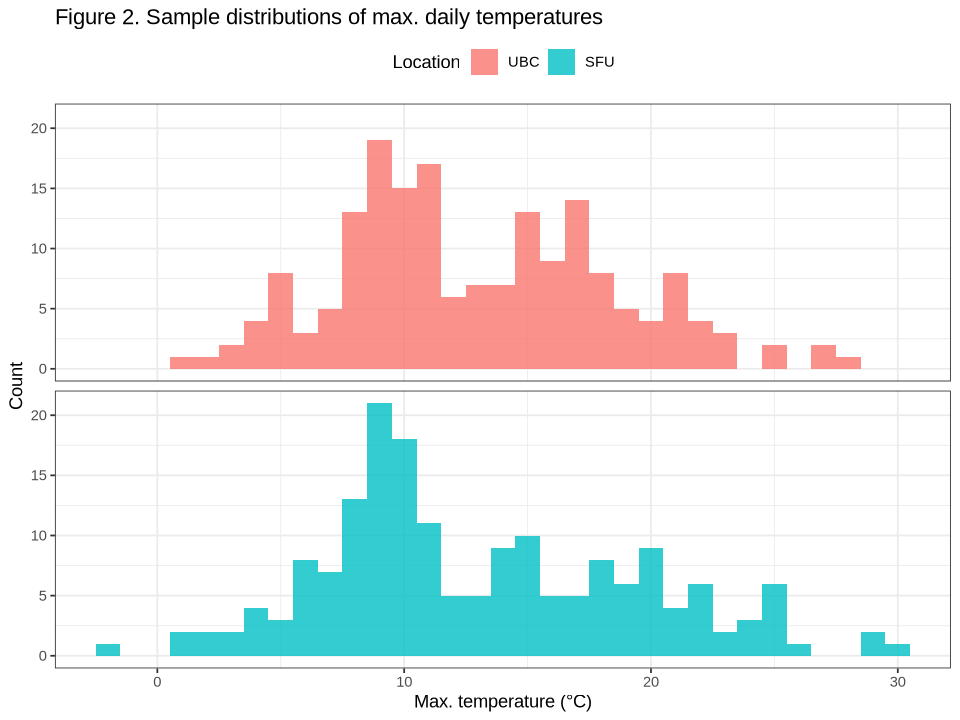

In [4]:
# Plot sample distributions for min. daily temperatures.
ubc_sfu_min_sample_dist <- ubc_sfu_data |>
    ggplot(aes(x = min_temp_c, fill = location)) +
        geom_histogram(binwidth = 1, alpha = 0.8) +
        labs(title = "Figure 1. Sample distributions of min. daily temperatures",
             x = "Min. temperature (°C)", y = "Count", fill = "Location") +
        facet_wrap(~location, ncol = 1) +
        theme_bw() +
        theme(legend.position = "top", 
              strip.background = element_blank(), strip.text = element_blank())

# Plot sample distributions for max. daily temperatures.
ubc_sfu_max_sample_dist <- ubc_sfu_data |>
    ggplot(aes(x = max_temp_c, fill = location)) +
        geom_histogram(binwidth = 1, alpha = 0.8) +
        labs(title = "Figure 2. Sample distributions of max. daily temperatures",
             x = "Max. temperature (°C)", y = "Count", fill = "Location") +
        facet_wrap(~location, ncol = 1) +
        theme_bw() +
        theme(legend.position = "top", 
              strip.background = element_blank(), strip.text = element_blank())

ubc_sfu_min_sample_dist
ubc_sfu_max_sample_dist

To get a better idea of the centers and spreads of the sample distributions, we can also compare boxplots. We see that both sample distributions for minimum and maximum daily temperatures (especially SFU's maximum temperatures) are slightly right-skewed.

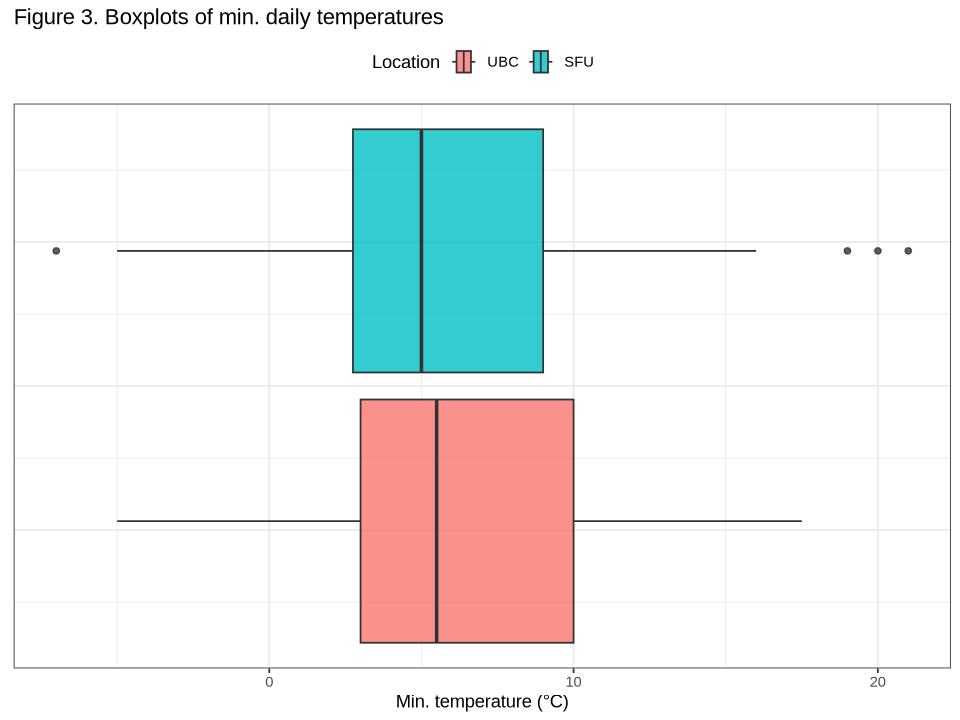

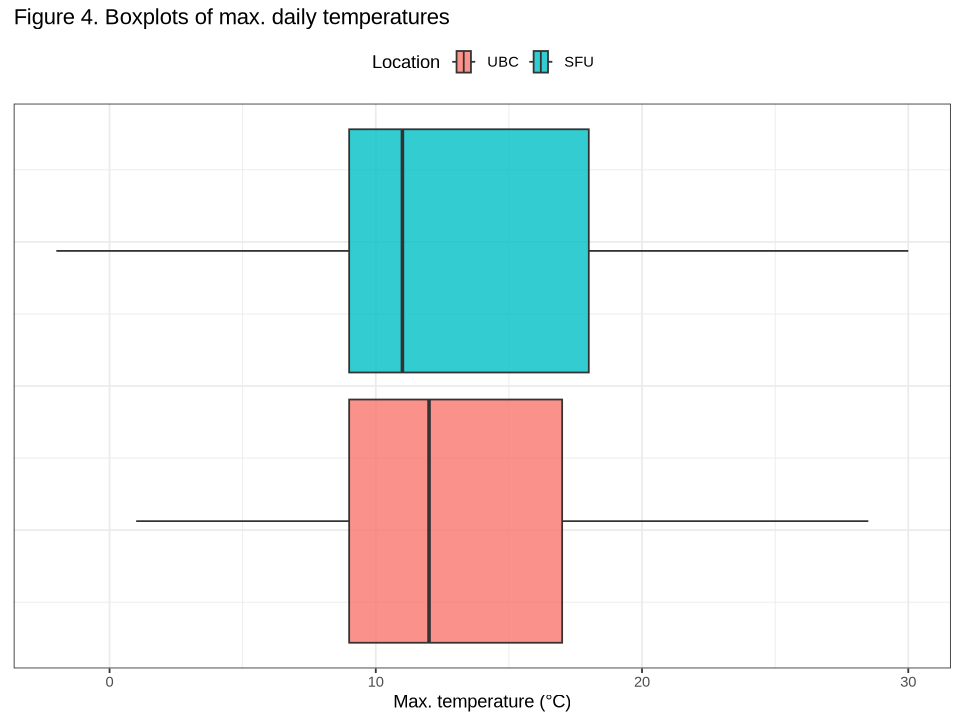

In [5]:
# Create boxplots for min. daily temperatures.
ubc_sfu_min_boxplot <- ubc_sfu_data |>
    ggplot(aes(x = min_temp_c, fill = location)) +
        geom_boxplot(alpha = 0.8) + 
        labs(title = "Figure 3. Boxplots of min. daily temperatures",
             x = "Min. temperature (°C)", fill = "Location") +
        theme_bw() +
        theme(legend.position = "top", 
              axis.text.y = element_blank(), axis.ticks.y = element_blank())

# Create boxplots for max. daily temperatures.
ubc_sfu_max_boxplot <- ubc_sfu_data |>
    ggplot(aes(x = max_temp_c, fill = location)) +
        geom_boxplot(alpha = 0.8) + 
        labs(title = "Figure 4. Boxplots of max. daily temperatures",
             x = "Max. temperature (°C)", fill = "Location") +
        theme_bw() +
        theme(legend.position = "top", 
              axis.text.y = element_blank(), axis.ticks.y = element_blank())

ubc_sfu_min_boxplot
ubc_sfu_max_boxplot

### 2.3 Data Analysis

#### 2.3.1. Plan

Our objective is to assess whether there is a statistically significant difference between the mean minimum and maximum daily temperatures at UBC and SFU. Although we have computed summary statistics for our sample, single point estimates do not provide sufficient evidence (Table 2). Hence, we will use the more robust method of hypothesis tests to draw conclusions about the population.

The first hypothesis test will assess whether there is a difference in the mean minimum daily temperatures at UBC and SFU at the 5% significance level. The second hypothesis test will do the same, but for the mean maximum daily temperatures instead. Let $\mu_1$ represent the mean minimum or maximum daily temperature at UBC and $\mu_2$ the same for SFU. Then, both hypothesis tests can be summarized as follows.

$$H_0 : \mu_1 = \mu_2, \quad H_A : \mu_1 \neq \mu_2, \quad \alpha = 0.05$$

Despite the slight skew found in our preliminary results, our sample is sufficiently large and consists of randomly and independently sampled data, which satisfies the assumptions of the CLT (Table 2, Figures 1–4). Hence, each hypothesis test will be performed once using an asymptotic method, then again using a bootstrapping method. We will first perform a two-sample t-test in order to calculate a p-value for the hypothesis test. Additionally, we will report a 95% confidence interval for each population parameter. We will then perform a two-sample permutation test in order to obtain an alternative p-value and confidence intervals. 

The results of both methods will be compared and contrasted, though we expect that the two methods should produce similar results. To conclude, we will either reject or fail to reject our null hypotheses based on the calculated p-values from both methods, addressing our research objective.

#### 2.3.2 Two-sample t-tests

Recall that our sample sizes for UBC and SFU are 181 and 179, respectively. Hence, we will use the Central Limit Theorem to assume that the sampling distributions for both populations will be roughly normal. 

Unfortunately, we do not have access to the population standard deviations of the mean minimum and maximum daily temperatures at UBC and SFU. Though we can compute standard errors from our sample data, we cannot be certain that they will reasonably approximate the population standard deviations either. As a result, we opt to conduct two-sample t-tests rather than z-tests.

In [6]:
# Split the datasets.
ubc_data <- ubc_sfu_data |>
    filter(location == "UBC")

sfu_data <- ubc_sfu_data |>
    filter(location == "SFU")

# Conduct a two-sample t-test for the difference in mean min. daily temperatures.
min_t_test <- 
    t.test(x = ubc_data$min_temp_c, y = sfu_data$min_temp_c, 
           alternative = "two.sided", conf.level = 0.95) |>
    tidy() |>
    select(p.value:alternative)

cat("Table 3. Two-sample t-test for difference in mean min. daily temperatures")
min_t_test

Table 3. Two-sample t-test for difference in mean min. daily temperatures

p.value   parameter conf.low   conf.high method                  alternative
1 0.3177157 357.9693  -0.4905347 1.506646  Welch Two Sample t-test two.sided

We begin with the hypothesis test for the mean minimum daily temperature. From the output of the `t.test`, we can see that the p-value for our two-sample t-test is about 0.3177. This means that under the null hypothesis, there is about a 31.77% chance of observing a result as extreme as that of the alternative hypothesis. Therefore, at the 5% significance level, we fail to reject the null hypothesis that the mean minimum daily temperatures at UBC and SFU are the same.

In [7]:
# Get the degrees of freedom from the t.test.
min_df <- min_t_test$parameter

# Calculate a confidence interval for a two-sample difference in means.
min_ci <- tibble(
    lower_ci = ubc_mean_min - sfu_mean_min + qt(0.025, df = min_df) * 
               sqrt(ubc_sd_min^2 / ubc_n + sfu_sd_min^2 / sfu_n),
    upper_ci = ubc_mean_min - sfu_mean_min + qt(0.975, df = min_df) * 
               sqrt(ubc_sd_min^2 / ubc_n + sfu_sd_min^2 / sfu_n)
)

# Print the observed difference for reference.
cat("Observed difference in mean min. daily temperatures: \n", 
    ubc_mean_min - sfu_mean_min, "\n\n")

cat("Table 4. 95% confidence interval for difference in mean min. daily \n",
    "temperatures using t-distribution")
min_ci

Observed difference in mean min. daily temperatures: 
 0.5080558 

Table 4. 95% confidence interval for difference in mean min. daily 
 temperatures using t-distribution

lower_ci   upper_ci
1 -0.4905347 1.506646

To verify the results of our `t.test`, we manually calculate a 95% confidence interval of about \[-0.4905, 1.507\] for the difference in mean minimum daily temperatures at UBC and SFU, which exactly matches the test. 

In other words, we are 95% confident that the true difference in mean minimum daily temperature between UBC and SFU is between -0.4905 and 1.507. Since the interval contains 0, it makes sense that we fail to reject the null hypothesis because it is plausible that there is no difference in the mean maximum daily temperature at UBC and SFU.

In [8]:
# Conduct a two-sample t-test for the difference in mean max. daily temperatures.
max_t_test <- 
    t.test(x = ubc_data$max_temp_c, y = sfu_data$max_temp_c, 
           alternative = "two.sided", conf.level = 0.95) |>
    tidy() |>
    select(p.value:alternative)

cat("Table 5. Two-sample t-test for difference in mean max. daily temperatures")
max_t_test

Table 5. Two-sample t-test for difference in mean max. daily temperatures

p.value   parameter conf.low  conf.high method                  alternative
1 0.9878319 350.0479  -1.244604 1.225436  Welch Two Sample t-test two.sided

Repeating the same process for the mean maximum daily temperature, the p-value for our two-sample t-test is about 0.9878. This means that under the null hypothesis, there is about a 98.78% chance of observing a result as extreme as that of the alternative hypothesis. Therefore, at the 5% significance level, we fail to reject the null hypothesis that the mean maximum daily temperatures at UBC and SFU are the same.

In [9]:
# Get the degrees of freedom from the t.test.
max_df <- max_t_test$parameter

# Calculate a confidence interval for a two-sample difference in means.
max_ci <- tibble(
    lower_ci = ubc_mean_max - sfu_mean_max + qt(0.025, df = max_df) * 
               sqrt(ubc_sd_max^2 / ubc_n + sfu_sd_max^2 / sfu_n),
    upper_ci = ubc_mean_max - sfu_mean_max + qt(0.975, df = max_df) * 
               sqrt(ubc_sd_max^2 / ubc_n + sfu_sd_max^2 / sfu_n)
)

# Print the observed difference for reference.
cat("Observed difference in mean max. daily temperatures: \n", 
    ubc_mean_max - sfu_mean_max, "\n\n")

cat("Table 6. 95% confidence interval for difference in mean max. daily \n",
    "temperatures using t-distribution")
max_ci

Observed difference in mean max. daily temperatures: 
 -0.009583629 

Table 6. 95% confidence interval for difference in mean max. daily 
 temperatures using t-distribution

lower_ci  upper_ci
1 -1.244604 1.225436

To verify the results of our `t.test`, we again manually calculate a 95% confidence interval of about \[-1.245, 1.225\] for the difference in mean maximum daily temperatures at UBC and SFU. 

In other words, we are 95% confident that the true difference in mean maximum daily temperature between UBC and SFU is between -1.245 and 1.225. Similarly, since the interval contains 0, it makes sense that we fail to reject the null hypothesis.

### 2.3.3 Two-sample permutation tests

We will now use bootstrapping to conduct the same hypothesis tests and obtain confidence intervals as above. Repeating the hypothesis tests using two different methods will help us ensure the validity of our results.

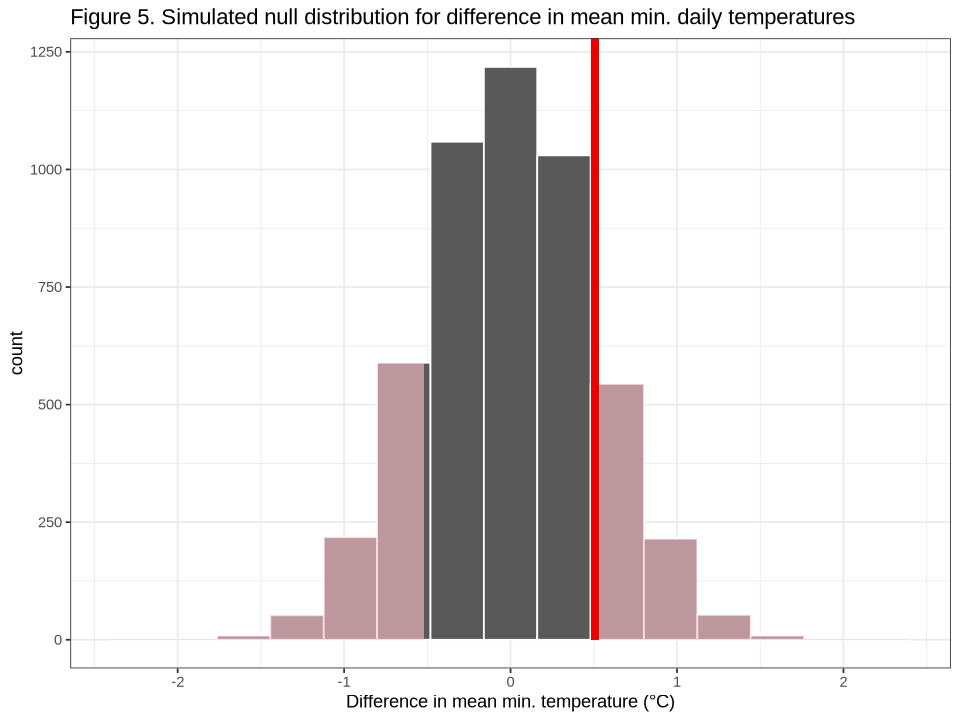

In [10]:
set.seed(2023)

# Obtain a simulated null distribution using 5000 resamples.
null_min <- ubc_sfu_data |>
    specify(min_temp_c ~ location) |>
    hypothesize(null = "independence") |>
    generate(reps = 5000, type = "permute") |>
    calculate(stat = "diff in means", order = c("UBC", "SFU"))

# Visualize the approximated sampling distribution under the null hypothesis.
null_dist_min <- null_min |>
    visualize(alpha = 0.8) +
    shade_p_value(obs_stat = ubc_mean_min - sfu_mean_min, direction = "two-sided") +
    labs(title = "Figure 5. Simulated null distribution for difference in mean min. daily temperatures",
         x = "Difference in mean min. temperature (°C)") +
    theme_bw()    

null_dist_min

As before, we begin with the hypothesis test for the mean minimum daily temperature. Based on the simulated null distribution, it appears that the observed difference in mean minimum daily temperatures at UBC and SFU is quite likely to occur even under the null hypothesis. To confirm, we can examine the p-value.

In [11]:
# Get the p-value for the observed difference.
diff_min_p <- null_min |>
    get_p_value(obs_stat = ubc_mean_min - sfu_mean_min, direction = "two-sided") 

cat("Table 7. p-value for two-sided hypothesis test for difference \n",
    "in mean min. daily temperatures using bootstrapping")
diff_min_p

Table 7. p-value for two-sided hypothesis test for difference 
 in mean min. daily temperatures using bootstrapping

p_value
1 0.3096

From our two-sample permutation test, we obtain a p-value of 0.3096, which is quite close to the that of the two-sample t-test (0.3177). Because of this, we reach the same conclusion at the 5% significance level—we fail to reject the null hypothesis that the mean minimum daily temperatures at UBC and SFU are the same.

Table 8. 95% confidence interval for difference in mean min. daily 
 temperatures using bootstrap distribution

lower_ci   upper_ci
1 -0.4411245 1.497218

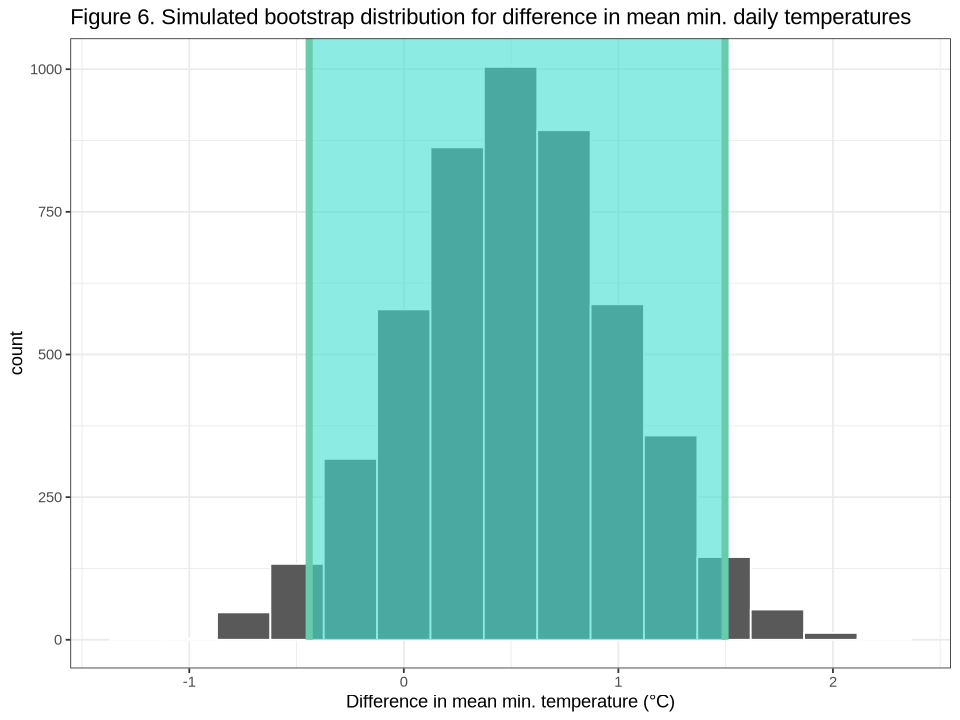

In [12]:
set.seed(2023)

# Obtain a simulated bootstrap distribution using 5000 resamples.
bootstrap_min <- ubc_sfu_data |>
    specify(min_temp_c ~ location) |>
    generate(reps = 5000, type = "bootstrap") |>
    calculate(stat = "diff in means", order = c("UBC", "SFU")) 

# Calculate and visualize the confidence interval.
bootstrap_min_ci <- bootstrap_min |>
    summarize(lower_ci = quantile(stat, 0.025), 
              upper_ci = quantile(stat, 0.975))

bootstrap_min_ci_plot <- bootstrap_min |>
    visualize(alpha = 0.8) +
    shade_ci(bootstrap_min_ci) +
    labs(title = "Figure 6. Simulated bootstrap distribution for difference in mean min. daily temperatures",
         x = "Difference in mean min. temperature (°C)") +
    theme_bw()

cat("Table 8. 95% confidence interval for difference in mean min. daily \n",
    "temperatures using bootstrap distribution")
bootstrap_min_ci
bootstrap_min_ci_plot

Next, we find a 95% confidence interval of about \[-0.4411, 1.497\] for the difference in mean minimum daily temperatures at UBC and SFU using bootstrapping. Again, our result is similar to the one obtained using the t-distribution (\[-0.4905, 1.507\]). Like before, the interval contains 0, which supports our failure to reject the null hypothesis.

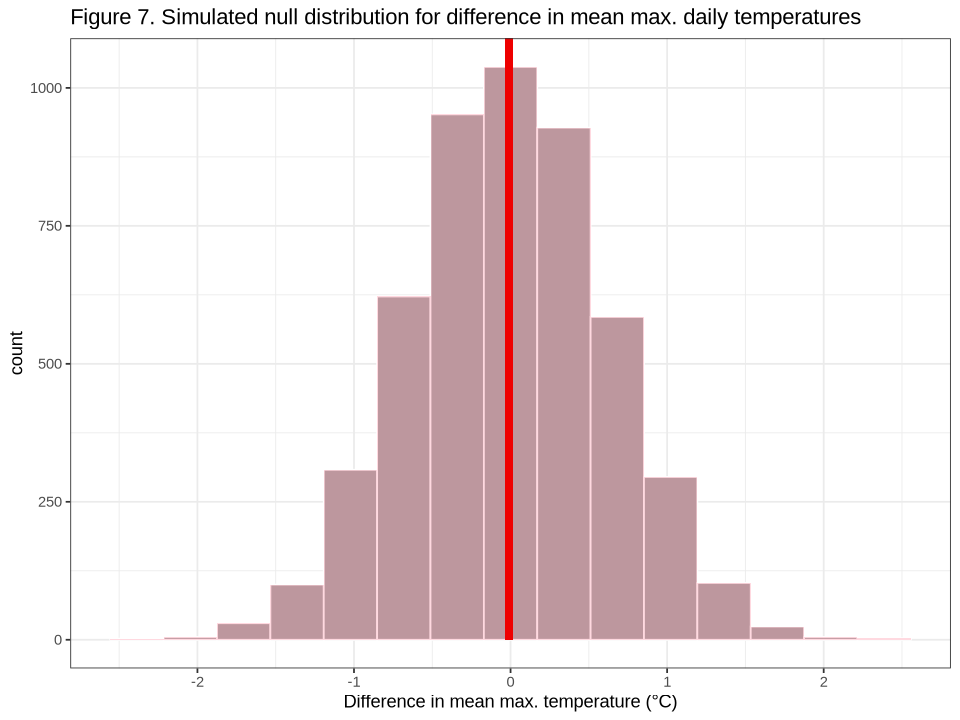

In [13]:
set.seed(2023)

# Obtain a simulated null distribution using 5000 resamples.
null_max <- ubc_sfu_data |>
    specify(max_temp_c ~ location) |>
    hypothesize(null = "independence") |>
    generate(reps = 5000, type = "permute") |>
    calculate(stat = "diff in means", order = c("UBC", "SFU"))

# Visualize the approximated sampling distribution under the null hypothesis.
null_dist_max <- null_max |>
    visualize(alpha = 0.8) +
    shade_p_value(obs_stat = ubc_mean_max - sfu_mean_max, direction = "two-sided") +
    labs(title = "Figure 7. Simulated null distribution for difference in mean max. daily temperatures",
         x = "Difference in mean max. temperature (°C)") +
    theme_bw()

null_dist_max

We repeat this process for the mean maximum daily temperature. Based on the null distribution, we can easily tell that we will almost certainly fail to reject the null hypothesis, since the observed difference in mean maximum daily temperatures at UBC and SFU is very likely to occur under the null hypothesis. We will find the p-value anyways.

In [14]:
# Get the p-value for the observed difference.
diff_max_p <- null_max |>
    get_p_value(obs_stat = ubc_mean_max - sfu_mean_max, direction = "two-sided") 

cat("Table 9. p-value for two-sided hypothesis test for difference \n",
    "in mean max. daily temperatures using bootstrapping")
diff_max_p

Table 9. p-value for two-sided hypothesis test for difference 
 in mean max. daily temperatures using bootstrapping

p_value
1 0.9964

Our p-value of 0.9964 is quite close to that of the two-sample t-test (0.9878). Hence, at the 5% significance level, we fail to reject the null hypothesis that the mean maximum daily temperatures at UBC and SFU are the same.

Table 10. 95% confidence interval for difference in mean max. daily 
 temperatures using bootstrap distribution

lower_ci  upper_ci
1 -1.200007 1.232599

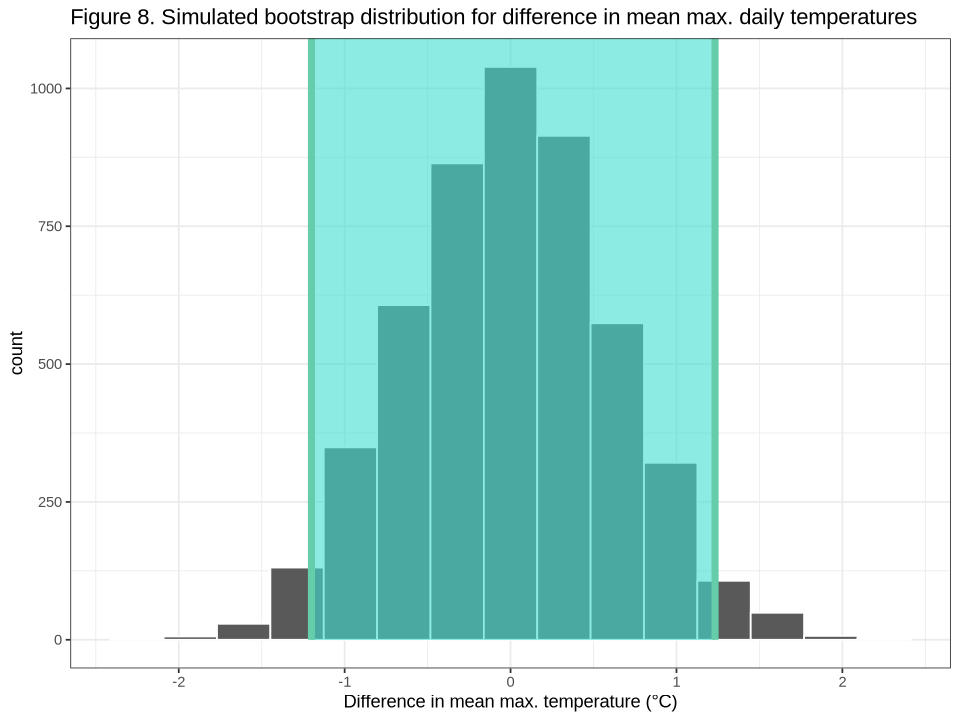

In [15]:
set.seed(2023)

# Obtain a simulated bootstrap distribution using 5000 resamples.
bootstrap_max <- ubc_sfu_data |>
    specify(max_temp_c ~ location) |>
    generate(reps = 5000, type = "bootstrap") |>
    calculate(stat = "diff in means", order = c("UBC", "SFU")) 

# Calculate and visualize the confidence interval.
bootstrap_max_ci <- bootstrap_max |>
    summarize(lower_ci = quantile(stat, 0.025), 
              upper_ci = quantile(stat, 0.975))

bootstrap_max_ci_plot <- bootstrap_max |>
    visualize(alpha = 0.8) +
    shade_ci(bootstrap_max_ci) +
    labs(title = "Figure 8. Simulated bootstrap distribution for difference in mean max. daily temperatures",
         x = "Difference in mean max. temperature (°C)") +
    theme_bw()

cat("Table 10. 95% confidence interval for difference in mean max. daily \n",
    "temperatures using bootstrap distribution")
bootstrap_max_ci
bootstrap_max_ci_plot

Finally, we find a 95% confidence interval of about \[-1.200, 1.233\] for the difference in mean maximum daily temperatures at UBC and SFU using bootstrapping, which is similar to the one obtained using the t-distribution (\[-1.245, 1.225\]). The interval contains 0, which supports our failure to reject the null hypothesis.

## 3. Discussion

<span style="color:red">TODO</span>

## 4. References

1. Beecher, M. E., Eggett, D., Erekson, D., Rees, L. B., Bingham, J., Klundt, J., Bailey, R. J., Ripplinger, C., Kirchhoefer, J., Gibson, R., Griner, D., Cox, J. C., & Boardman, R. D. (2016). Sunshine on my shoulders: Weather, pollution, and emotional distress. *Journal of Affective Disorders, 205*, 234–238. https://doi.org/10.1016/j.jad.2016.07.021 

2. Barnston, A. G. (1988). The effect of weather on mood, productivity, and frequency of emotional crisis in a temperate continental climate. *International Journal of Biometeorology, 32(2)*, 134–143. https://doi.org/10.1007/bf01044907 

3. Alberto, I., Jiao, Y., & Zhang, X. (2021). Too hot or too cold to study? the effect of temperature on student time allocation. *Economics of Education Review, 84*, 102152. https://doi.org/10.1016/j.econedurev.2021.102152 

4. Environment and Climate Change Canada Historical Climate Data. Retrieved October 30, 2023, from https://climate.weather.gc.ca/index_e.html 

5. Canada, E. and C. C. (2023). Retrieved from https://climate.weather.gc.ca/climate_data/data_quality_e.html 

<span style="color:red">TODO</span>